# Krishna Siddhardh Potluri


**The goal is to guess whether the individuals from the test dataset had survived or not.**

**We will start by importing necessary packages for preprocessing and calculating the classification accuracy for this dataset.**

In [139]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

## 1: Preprocessing the training data

In [140]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
print(train_data.head())
print('')
print(test_data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  

 

In [141]:
print(train_data.isnull().sum())
print('')
print(test_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


**• Created 'Deck'** — extracted the first letter from *Cabin*; used *'M'* for missing values.  
*Assumption:* Deck may impact lifeboat access. Missing values filled to avoid training issues.

**• Extracted 'Title'** — pulled honorifics (e.g., *Mr.*, *Miss*) from *Name* using regex.  
*Assumption:* Reduces model complexity, helps prevent overfitting, and improves clarity.


In [142]:
def extract_deck(cabin):
    return cabin[0] if pd.notna(cabin) else 'M'

def extract_title(name):
    return name.str.extract(' ([A-Za-z]+)\.', expand=False)

for dataset in [train_data, test_data]:
    dataset['Deck'] = dataset['Cabin'].apply(extract_deck)
    dataset['Title'] = extract_title(dataset.Name)

In [143]:
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
title_mapping = {
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs'
}

# Add rare titles to the mapping dictionary
for title in rare_titles:
    title_mapping[title] = 'Rare'

# Apply the mapping to both datasets in one loop
for dataset in [train_data, test_data]:
    dataset['Title'] = dataset['Title'].replace(title_mapping)

**• Used KNNImputer** — likely gave more accurate 'Age' estimates by leveraging similarities between passengers.  
*Assumption:* A fully populated 'Age' feature helps the model find age-related survival patterns.  
*Also assumed:* Using mode for 'Embarked' fills missing values more effectively than mean or median.

**• Converted categorical variables** into binary indicators to prepare them for machine learning models.  
*Assumption:* Algorithms perform better with numerical inputs due to improved statistical efficiency.

**• Removed irrelevant features** to reduce noise and improve model focus.  
*Assumption:* Dropping unhelpful data can enhance model performance and interpretability.



In [144]:
def impute_missing_values(train_df, test_df):
    imputer = KNNImputer(n_neighbors=7)
    train_df['Age'] = imputer.fit_transform(train_df[['Age']])
    test_df['Age'] = imputer.transform(test_df[['Age']])
    
    for df in [train_df, test_df]:
        df.fillna({'Embarked': df['Embarked'].mode()[0]}, inplace=True)
    
    return train_df, test_df

def encode_categorical_features(train_df, test_df):
    categorical_columns = ['Sex', 'Embarked', 'Title', 'Deck']
    train_df = pd.get_dummies(train_df, columns=categorical_columns)
    test_df = pd.get_dummies(test_df, columns=categorical_columns)
    
    missing_cols = set(train_df.columns) - set(test_df.columns)
    for col in missing_cols:
        test_df[col] = 0
        
    test_df = test_df[train_df.columns]
    
    return train_df, test_df

def remove_unnecessary_features(train_df, test_df):
    noise_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    
    train_df = train_df.drop(noise_columns, axis=1)
    
    test_columns_to_drop = noise_columns.copy()
    if "Survived" in test_df.columns:
        test_columns_to_drop.append("Survived")
    test_df = test_df.drop(test_columns_to_drop, axis=1)
    
    return train_df, test_df

train_data, test_data = impute_missing_values(train_data, test_data)
train_data, test_data = encode_categorical_features(train_data, test_data)
train_data, test_data = remove_unnecessary_features(train_data, test_data)

**Standardization.**



In [145]:
scal = StandardScaler()
Y_train = train_data["Survived"]
train_data = train_data.drop("Survived", axis=1)
X_train_scaled = scal.fit_transform(train_data)
X_train = pd.DataFrame(X_train_scaled, columns=train_data.columns)
X_test_scaled = scal.transform(test_data)
X_test = pd.DataFrame(X_test_scaled, columns=test_data.columns)

## 2: Learn and fine-tune a decision tree model with the Titanic training data

**• Trained and fine-tuned a decision tree model** using the Titanic training data.  
*Assumption:* Validation on unseen data gave an unbiased performance check and served as a baseline for tuning.

**• Used grid search** to find the optimal set of hyperparameters:  
- *'max_depth'* — limits tree depth to avoid overfitting  
- *'min_samples_split'* — sets the minimum samples needed to split a node  
- *'min_samples_leaf'* — defines the minimum samples required at a leaf node



In [146]:
X_train, X_value, y_train, y_value = train_test_split(X_train, Y_train, test_size=0.2, random_state=35)

baseline_dt = DecisionTreeClassifier()
baseline_dt.fit(X_train, y_train)
baseline_accuracy = baseline_dt.score(X_value, y_value)

hyperparameter_grid = {
   'max_depth': [3, 5, 7, 10],
   'min_samples_split': [2, 5, 10],
   'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
   DecisionTreeClassifier(), 
   hyperparameter_grid, 
   cv=5, 
   scoring="accuracy"
)
grid_search.fit(X_train, y_train)

optimized_dt = grid_search.best_estimator_
optimized_accuracy = optimized_dt.score(X_value, y_value)

print(f"Decision Tree accuracy: {baseline_accuracy:.2f}")
print(f"Post Hyperparameter tuning, we get: {optimized_accuracy:.2f}")

Decision Tree accuracy: 0.77
Post Hyperparameter tuning, we get: 0.82


## Task 1.2: Plot your decision tree

**Plotting the decision tree**



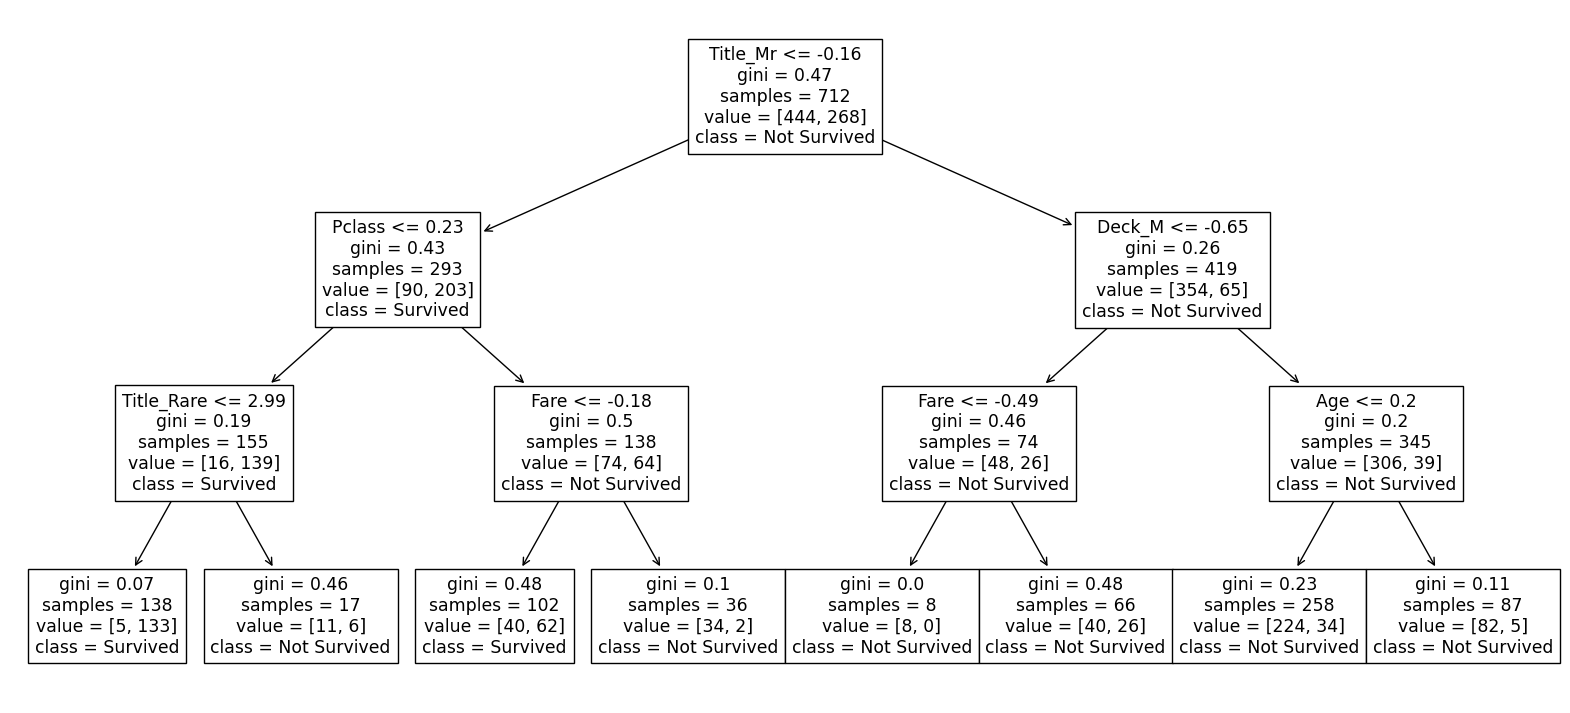

In [147]:
plt.figure(figsize=(20, 9))
plot_tree(optimized_dt, feature_names=X_train.columns,
          class_names=['Not Survived', 'Survived'],
          label='all', proportion=False,
          node_ids=False, precision=2)
plt.show()

## 3: Apply the five-fold cross validation of your fine-tuned decision tree learning model to the Titanic training data to extract average classification accuracy

**• Trained a Random Forest Classifier** to potentially boost performance over a single decision tree.  

**• Tuned hyperparameters** using grid search with cross-validation:  
- *'n_estimators'* — number of trees in the forest  
- Optimized parameter combinations to improve model performance


In [148]:
cross_validation_scores = cross_val_score(optimized_dt, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_accuracy = cross_validation_scores.mean()
print(f"Average Classification accuracy we get -> {mean_cv_accuracy:.4f}")

Average Classification accuracy we get -> 0.8119


## 4: Apply the five-fold cross validation of your fine-tuned random forest learning model to the Titanic training data to extract average classification accuracy

In [149]:

hyperparameter_grid['n_estimators'] = [50, 100, 150]

baseline_rf = RandomForestClassifier()
baseline_rf.fit(X_train, y_train)

rf_classifier = RandomForestClassifier(random_state=35)
rf_classifier.fit(X_train, y_train)

grid_search = GridSearchCV(rf_classifier, hyperparameter_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

optimized_rf = grid_search.best_estimator_

cross_validation_scores = cross_val_score(optimized_rf, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_accuracy = cross_validation_scores.mean()

print(f"Average Classification accuracy we get -> {mean_cv_accuracy:.4f}")

Average Classification accuracy we get -> 0.8287
